In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import *
import numpy as np
from itertools import product
import numpy as np
from numpy import pi
from qiskit.transpiler.passes import ApplyLayout
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.analysis.resource_estimation import ResourceEstimation
import sys
sys.path.append("..")
import fakeutils
from fakeutils.fakeutils import BasisTranslator
from fakeutils.equivalence_library import SessionEquivalenceLibrary, rootSwap, rootiSwap
from fakeutils.weyl_decompose import RootiSwapWeylDecomposition
_sel = SessionEquivalenceLibrary

In [2]:
# # from qiskit.quantum_info.synthesis.weyl import weyl_coordinates
from fakeutils.weyl import weyl_coordinates
# weyl_coordinates(Operator(CRZGate(np.pi/2)).data)
# #SessionEquivalenceLibrary.add_equivalence(g.SwapGate(), _rootSwapEquiv)

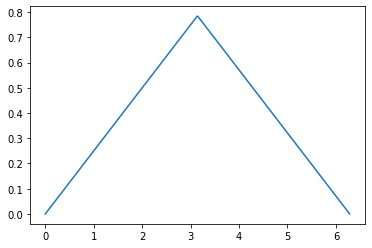

In [3]:
phase_arr = np.linspace(0, 2*np.pi, 500)
x_arr = np.zeros(len(phase_arr))
for i, phase in enumerate(phase_arr):
    x,y,z = weyl_coordinates(Operator(CPhaseGate(phase)).data)
    x_arr[i] = x
import matplotlib.pyplot as plt
plt.plot(phase_arr, x_arr)

Text(0, 0.5, 'Weyl x coordinate')

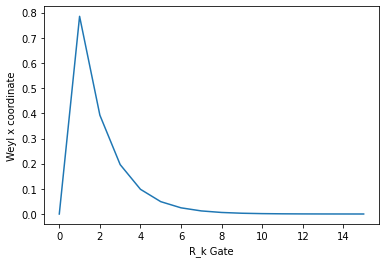

In [4]:
k_arr = np.arange(0, 2**4)
x_arr = np.zeros(len(k_arr))
for i, k in enumerate(k_arr):
    x,y,z = weyl_coordinates(np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0, np.exp(2*np.pi * 1j / 2**k)]]))
    x_arr[i] = x
import matplotlib.pyplot as plt
plt.plot(k_arr, x_arr)
plt.xlabel("R_k Gate")
plt.ylabel("Weyl x coordinate")
# plt.xscale('log')

In [5]:
#define rootiswap
circuit = QuantumCircuit(2, name="rootiswap")
cx = Operator(
    [
        [1, 0, 0, 0],
        [0, 1 / np.sqrt(2), 1j / np.sqrt(2), 0],
        [0, 1j / np.sqrt(2), 1 / np.sqrt(2), 0],
        [0, 0, 0, 1],
    ]
)

circuit.unitary(cx, [0, 1])
rootiSwap = circuit.to_gate()

0.3926990816987241


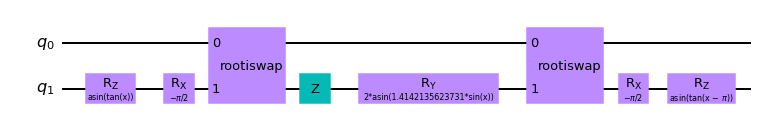

In [20]:
#q = QuantumRegister(2, "q")
#theta = Parameter("theta")
x,y,z = weyl_coordinates(Operator(CPhaseGate(np.pi/2)).data)
print(x)
x = Parameter('x')
def_cphase = QuantumCircuit(2)
def_cphase.rz(np.arcsin(np.tan(x)), 1)
def_cphase.rx(-np.pi/2, 1)
def_cphase.append(rootiSwap, [0,1])
def_cphase.z(1)
def_cphase.ry(2*np.arcsin(np.sqrt(2)*np.sin(x)), 1)
def_cphase.append(rootiSwap, [0,1])
def_cphase.rx(-np.pi/2, 1)
def_cphase.rz(np.arcsin(np.tan(x-np.pi)), 1)
#_sel.add_equivalence(CPhaseGate(np.pi/2), def_cphase)
def_cphase.draw(output='mpl')

In [7]:
ex = QuantumCircuit(1)
ex.ry(np.pi/9, 0)
bt = BasisTranslator(_sel, ['rz', 'y', 'h'])
re = ResourceEstimation()
pm = PassManager([bt, re])
circ_trans = pm.run(ex)
circ_trans.draw(output='mpl')
print(re.property_set)

{'depth': 9, 'width': 1, 'size': 9, 'count_ops': {'h': 2, 'rz': 7}, 'num_tensor_factors': 1, 'num_qubits': 1}


In [8]:
Operator(CRZGate(np.pi/2)).data

array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.70710678-0.70710678j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        1.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.70710678+0.70710678j]])

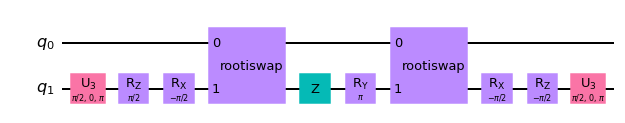

In [24]:
qc = QuantumCircuit(2)
qc.append(CXGate(), [0,1])
qc.draw(output='mpl')
bt = BasisTranslator(_sel, ['rz', 'u3', 'cz']) #first pass key to turn C(U)s into CPhase (CZ?)
pm = PassManager([bt, RootiSwapWeylDecomposition()])
circ_trans = pm.run(qc)
circ_trans.draw(output='mpl')

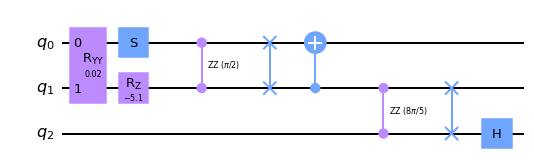

In [ ]:
# # random circuit

# delta = 8 * np.pi / 5
# epsilon = np.pi / 2
# eta = -5.1
# theta = 0.02

# qc = QuantumCircuit(3)
# qc.ryy(theta, 0, 1)
# qc.s(0)
# qc.rz(eta, 1)
# qc.rzz(epsilon, 0, 1)
# qc.swap(0, 1)
# qc.cx(1, 0)
# qc.rzz(delta, 1, 2)
# qc.swap(1, 2)
# qc.h(2)
# qc.draw(output='mpl')

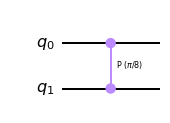

In [ ]:
qc = QuantumCircuit(2)
k = 4
qc.append(CPhaseGate(2*pi/2**k), [0,1])
qc.draw(output='mpl')


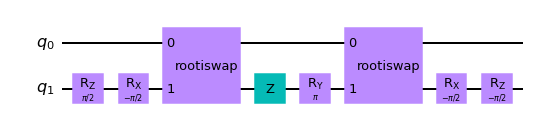

In [ ]:
# basis_pass = BasisTranslator(_sel, ['rootiswap', 'u3'])
basis_pass = RootiSwapWeylDecomposition()
pm = PassManager([basis_pass])
circ_trans = pm.run(qc)
circ_trans.draw(output='mpl')

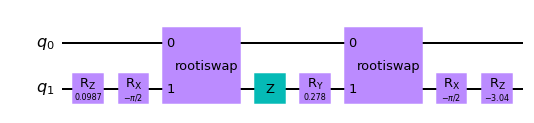

In [ ]:
# basis_pass = BasisTranslator(_sel, ['rootiswap', 'u3'])
basis_pass = RootiSwapWeylDecomposition()
pm = PassManager([basis_pass])
circ_trans = pm.run(qc)
circ_trans.draw(output='mpl')

In [ ]:
Operator(qc).equiv(circ_trans)
Operator(circ_trans).equiv(qc)

False

Example circuit

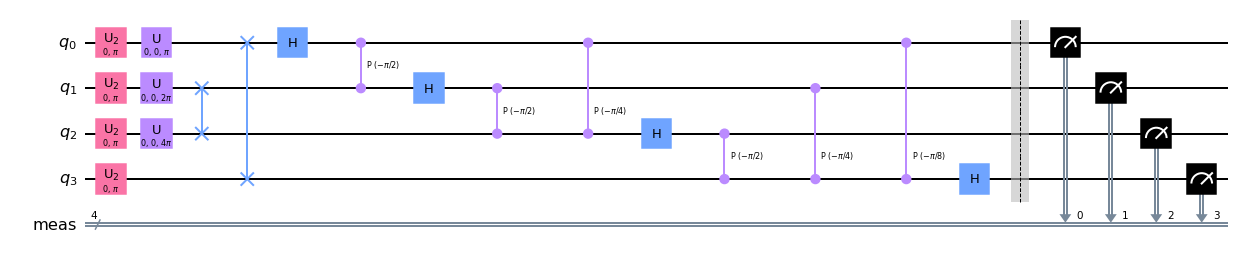

In [25]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

def getQFTCircuit(nqubits=4, number=5):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    qc.p(number*pi/4,0)
    qc.p(number*pi/2,1)
    qc.p(number*pi,2)

    qc = inverse_qft(qc, nqubits)
    qc.measure_all()
    return qc

example = getQFTCircuit(4,4)
example.draw(output='mpl')

In [30]:
qc = example.decompose().decompose()
basis_pass = BasisTranslator(SessionEquivalenceLibrary, ['cx', 'u3'])
re = ResourceEstimation()
pm = PassManager([basis_pass, re()])
circ_trans = pm.run(qc)
print(re.property_set)
circ_trans.draw(output='mpl')

TypeError: __call__() missing 1 required positional argument: 'circuit'

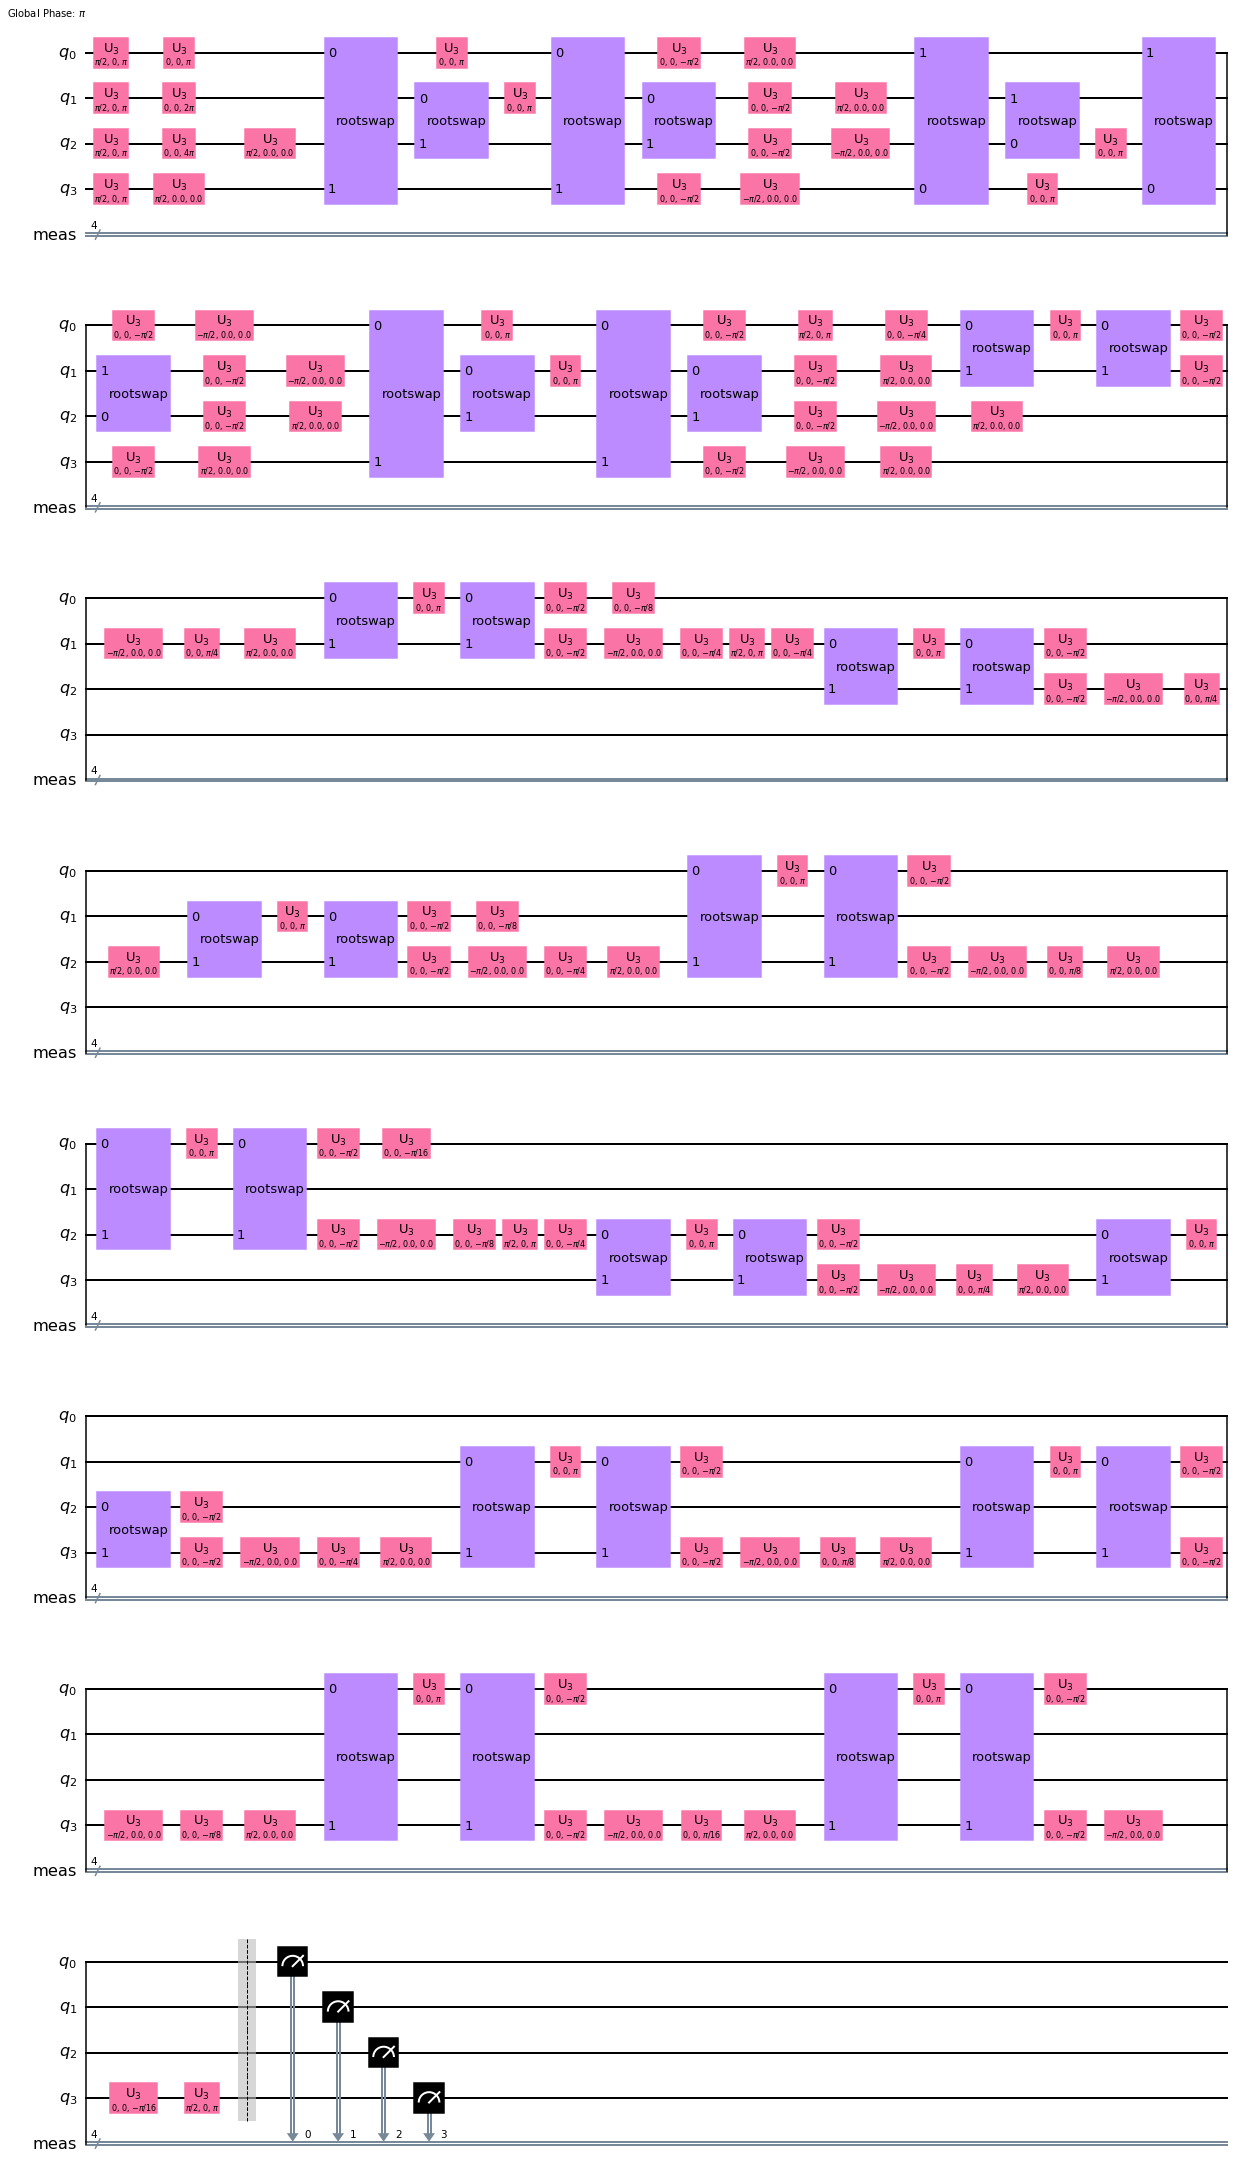

In [27]:
qc = example.decompose().decompose()
basis_pass = BasisTranslator(SessionEquivalenceLibrary, ['rootswap', 'u3'])
pm = PassManager([basis_pass])
circ_trans = pm.run(qc)
circ_trans.draw(output='mpl')

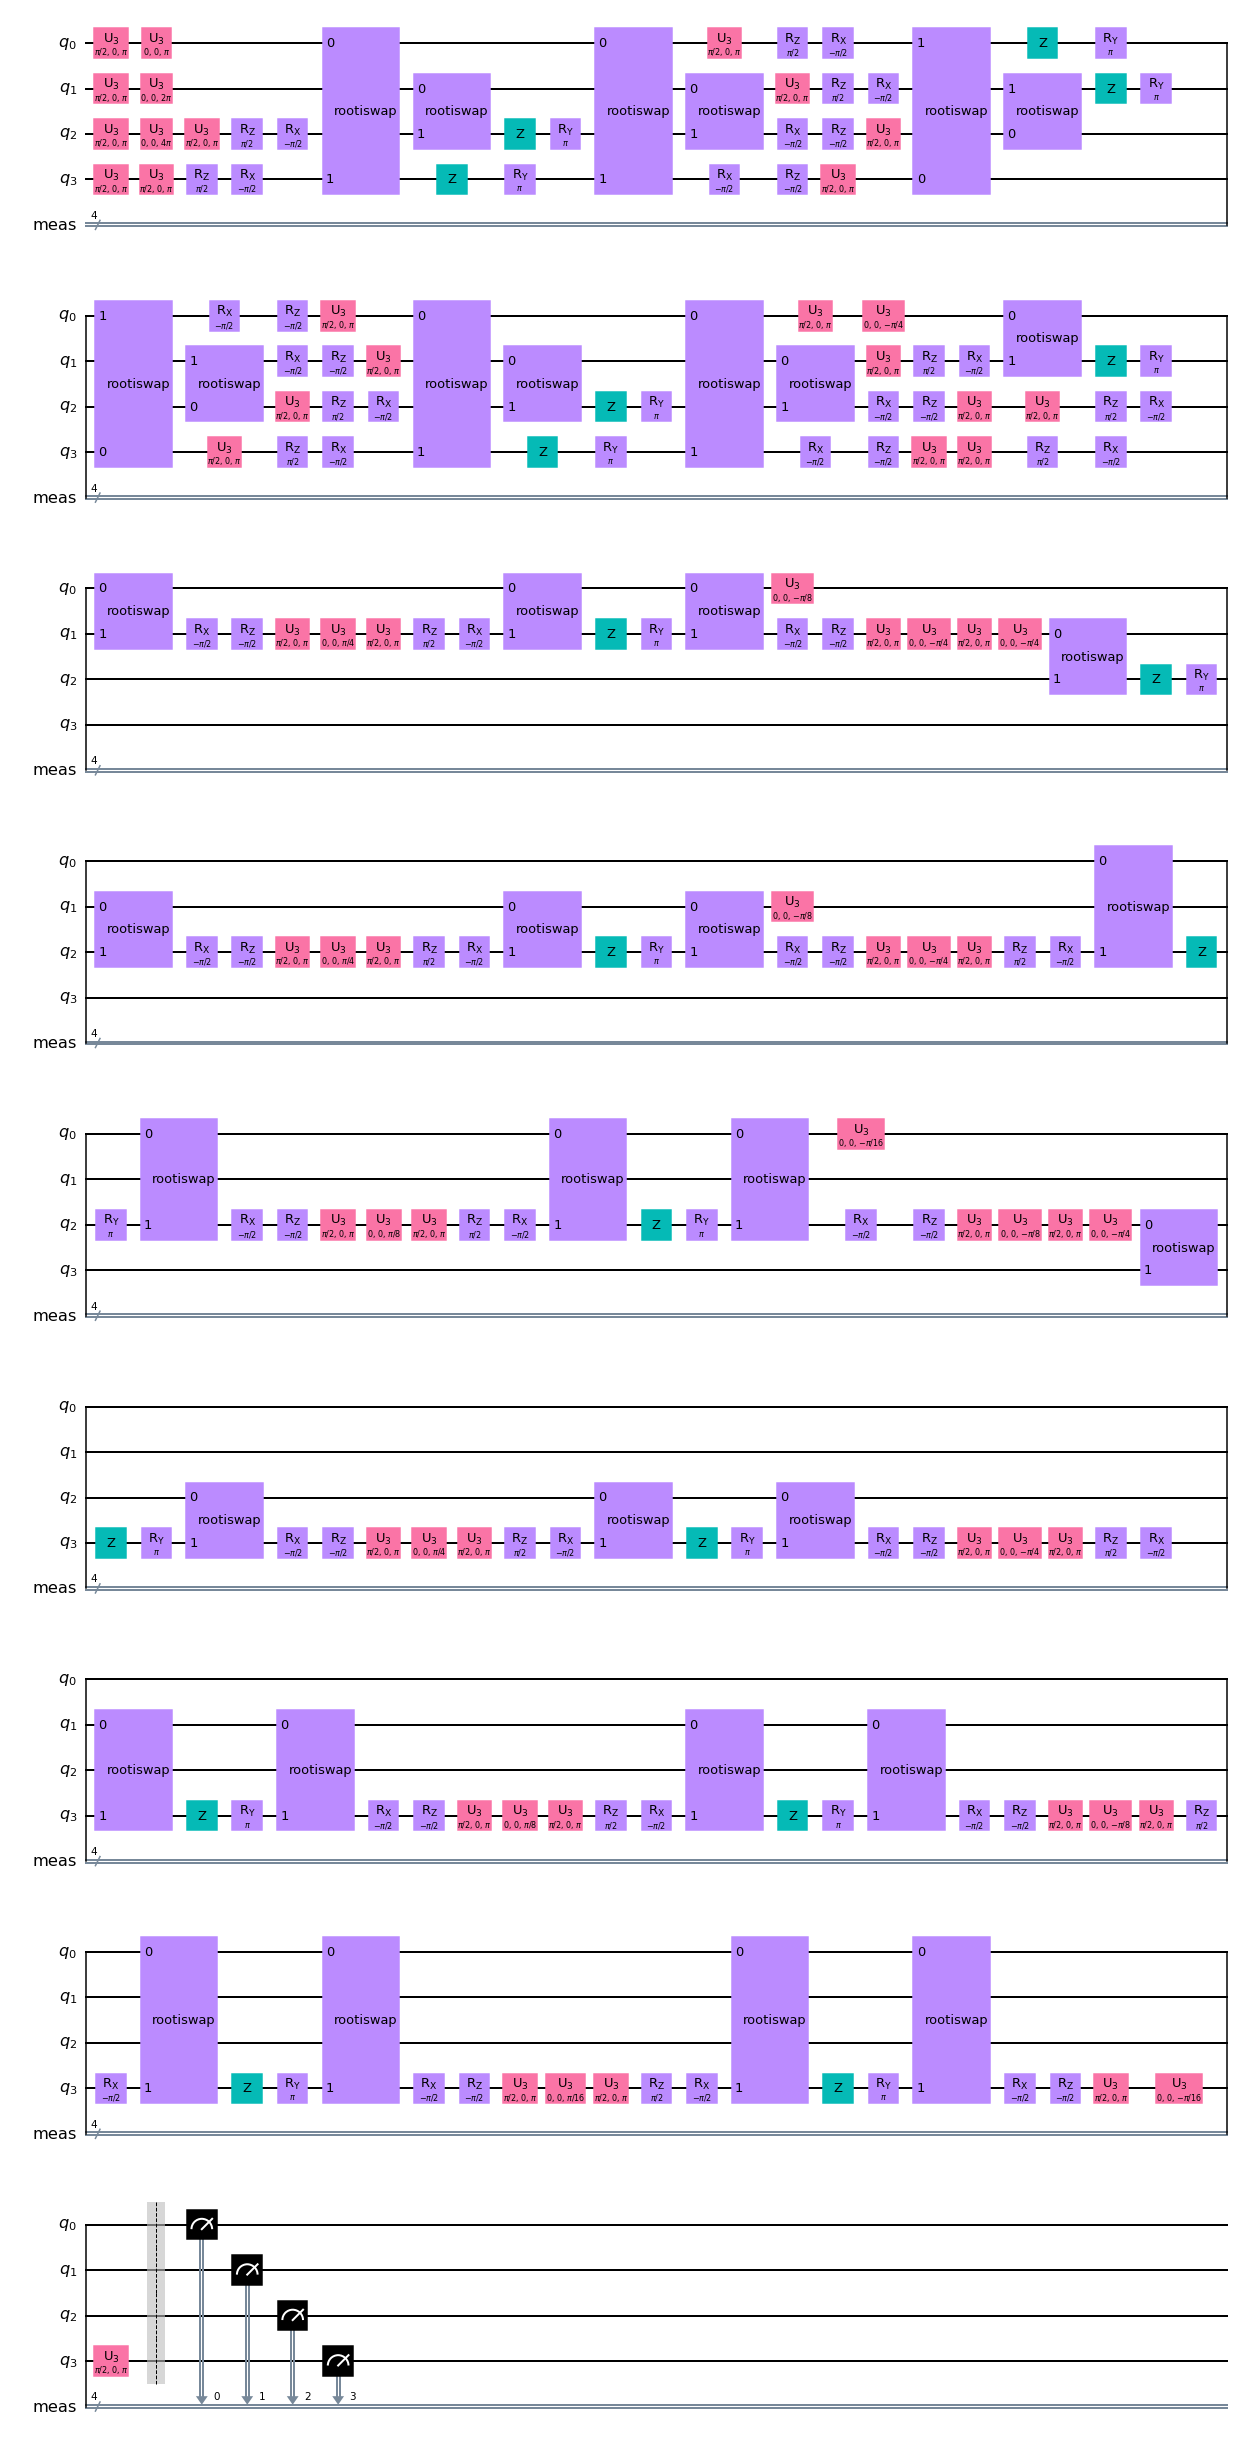

In [28]:
qc = example.decompose().decompose()
bt = BasisTranslator(_sel, ['rz', 'u3', 'cz']) #first pass key to turn C(U)s into CPhase (CZ?)
pm = PassManager([bt, RootiSwapWeylDecomposition()])
circ_trans = pm.run(qc)
circ_trans.draw(output='mpl')